In [1]:
import pandas as pd
import numpy as np
from collections import Counter

In [5]:
# afsluiters uit BM GIS laden in een dataframe
AFS = pd.read_excel('AFS_in_bedrijf_24_04_2018.xlsx', sheet_name=None)
Afsluiters = AFS['G afsluiter']

In [6]:
Afsluiters['Id'] = Afsluiters['Id'].fillna(0)
Afsluiters['Id'] = Afsluiters['Id'].astype(int)

In [7]:
# 'G inlaat' en 'G uitlaat' zijn gevuld als de afsluiter gekoppeld is met een station. Lege cellen gevuld met de string 'Leeg'
Afsluiters['G inlaat'] = Afsluiters['G inlaat'].fillna('Leeg')
Afsluiters['G uitlaat'] = Afsluiters['G uitlaat'].fillna('Leeg')

Afsluiters = Afsluiters.rename(columns = {'Id' : 'Id afsluiter'})
Afsluiters = Afsluiters.rename(columns = {'Soort' : 'Soort afsluiter'})

# Overige lege cellen worden gevuld met de string 'Onbekend'
Afsluiters = Afsluiters.fillna('Onbekend')

Afsluiters_inlaat = Afsluiters[Afsluiters['G inlaat'] != 'Leeg']
Afsluiters_inlaat = Afsluiters_inlaat.rename(columns = {'G inlaat' : 'Id station inlaat'})
Afsluiters_inlaat = Afsluiters_inlaat.drop(['G uitlaat'], axis=1)

Afsluiters_uitlaat = Afsluiters[Afsluiters['G uitlaat'] != 'Leeg']
Afsluiters_uitlaat = Afsluiters_uitlaat.rename(columns = {'G uitlaat' : 'Id station uitlaat'})
Afsluiters_uitlaat = Afsluiters_uitlaat.drop(['G inlaat'], axis=1)

Afsluiters_inlaat_en_uitlaat = Afsluiters[(Afsluiters['G inlaat'] != 'Leeg') & (Afsluiters['G uitlaat'] != 'Leeg')]
Afsluiters_inlaat_en_uitlaat = Afsluiters_inlaat_en_uitlaat.rename(columns = {'G inlaat' : 'Id station inlaat'})
Afsluiters_inlaat_en_uitlaat = Afsluiters_inlaat_en_uitlaat.rename(columns = {'G uitlaat' : 'Id station uitlaat'})

Station_afsluiters = pd.concat([Afsluiters_inlaat, Afsluiters_uitlaat, Afsluiters_inlaat_en_uitlaat])

In [12]:
[str(x) for x in Afsluiters.columns]

['Druk',
 'Identificatienummer',
 'Nummer',
 'G afsluiter type',
 'Status',
 'Functie',
 'Stand',
 'Aantal slagen',
 'Draairichting',
 'Opgetuigd J/N',
 'Volle doorlaat J/N',
 'Soort verbinding',
 'Projectnummer',
 'Jaar van eerste aanleg',
 'Opname (ligging)',
 'Kortste afstand tot station [m]',
 'G uitlaat',
 'G inlaat',
 'Dossiernummer',
 'Opvoer datum',
 'User id',
 'Wijzig datum',
 'Fabrikaat',
 'Soort afsluiter',
 'Type',
 'Diameter',
 'Id afsluiter']

In [13]:
# voeg een kolom to met het aantal onbekenden van de 5 relevante kolommen
eigenschappen = ['Identificatienummer', 'Type', 'Soort afsluiter', 'Fabrikaat', 'Functie']
Afsluiters['Aantal onbekenden'] = (Afsluiters[eigenschappen] == 'Onbekend').sum(axis=1)

In [14]:
Afsluiters = Afsluiters[['Jaar van eerste aanleg'] + eigenschappen + ['Aantal onbekenden', 'Id afsluiter']]

In [15]:
# afsluiters zijn soms gekoppeld aan stations
S = pd.read_excel('S_24_04_2018.xlsx', sheetname=None)

Stations = S['G station']
Stations = Stations.fillna('Onbekend')
Stations = Stations.rename(columns = {'Id' : 'Id station'})
Stations = Stations.rename(columns = {'Soort' : 'Soort station'})
Stations = Stations.rename(columns = {'Status' : 'Status station'})

In [100]:
def tel_bekendheid(Afsluiters, jaar = None):
    
    if jaar != None:
        Afsluiters = Afsluiters[Afsluiters['Jaar van eerste aanleg'] == jaar]
        
    eigenschappen = ['Identificatienummer', 'Type', 'Soort afsluiter', 'Fabrikaat', 'Functie']
    
    eigenschap_bekendheid = pd.DataFrame(index=['bekend', 'onbekend', '% bekend'], columns=eigenschappen)
    
    eigenschap_bekendheid.loc['bekend'] = (Afsluiters[eigenschappen] != 'Onbekend').sum()
    eigenschap_bekendheid.loc['onbekend'] = (Afsluiters[eigenschappen] == 'Onbekend').sum()
    eigenschap_bekendheid.loc['% bekend'] = (100 * eigenschap_bekendheid.loc['bekend'] / len(Afsluiters)).astype(int)
    
    eigenschap_bekendheid.columns.name = 'jaar: %s, aantal afsluiters: %i' % (jaar, len(Afsluiters))
    
    telling = (Afsluiters[eigenschappen] == 'Onbekend').sum(axis=1)
    aantal_onbekenden = telling.to_frame().groupby(0).size().to_frame('Aantal afsluiters')
    
    aantal_onbekenden.index.name = 'Aantal onbekenden eigenschappen'
    aantal_onbekenden.columns.name = 'jaar: %s, aantal afsluiters: %i' % (jaar, len(Afsluiters))
    
    return eigenschap_bekendheid, aantal_onbekenden

In [316]:
eigenschap_bekendheid, aantal_onbekenden = tel_bekendheid(Afsluiters)
eigenschap_bekendheid['Identificatienummer']['% bekend']

93

In [263]:
Afsluiters = Afsluiters[Afsluiters['Jaar van eerste aanleg'] >= 1960]
jaar_aantallen = Afsluiters.groupby('Jaar van eerste aanleg').size()
jaar_aantallen = jaar_aantallen.drop('Onbekend')
jaardata = Afsluiters[eigenschappen] != 'Onbekend'
jaardata['Jaar van eerste aanleg'] = Afsluiters['Jaar van eerste aanleg']
jaardata = jaardata.groupby('Jaar van eerste aanleg').sum().divide(0.01 * jaar_aantallen, axis=0).drop(['Onbekend', 2018.0]).astype(int)
jaardata.index = jaardata.index.astype(int)

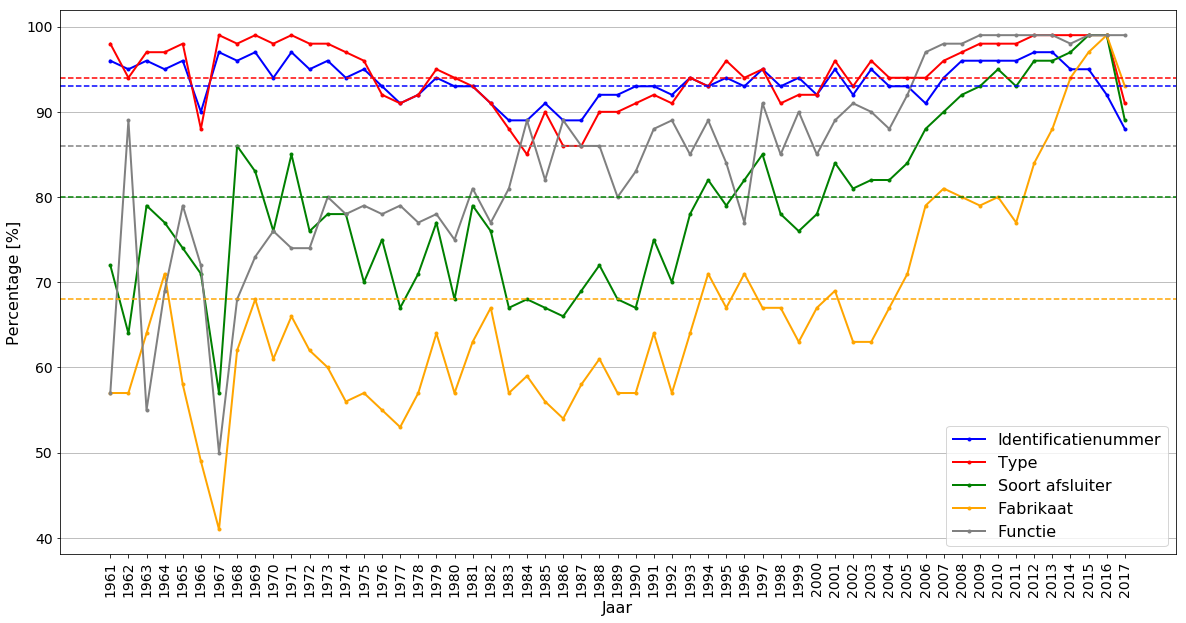

In [317]:
import matplotlib.pyplot as plt
ax = jaardata.plot(figsize=(20, 10), fontsize=14, xticks=jaardata.index,
                   rot=90,
                   style='.-',
                   linewidth=2,
                   color = ['blue', 'red', 'green', 'orange', 'gray'])
ax.legend(fontsize = 16)
plt.xlabel('Jaar' ,fontsize=16)
plt.ylabel('Percentage [%]', fontsize=16)
plt.grid(axis='y')
plt.axhline(y=eigenschap_bekendheid['Identificatienummer']['% bekend'], color='blue', linestyle='--')
plt.axhline(y=eigenschap_bekendheid['Type']['% bekend'], color='red', linestyle='--')
plt.axhline(y=eigenschap_bekendheid['Soort afsluiter']['% bekend'], color='green', linestyle='--')
plt.axhline(y=eigenschap_bekendheid['Fabrikaat']['% bekend'], color='orange', linestyle='--')
plt.axhline(y=eigenschap_bekendheid['Functie']['% bekend'], color='gray', linestyle='--')
plt.show()

In [105]:
eigenschap_bekendheid, aantal_onbekenden = tel_bekendheid(Afsluiters, 1987)
eigenschap_bekendheid

"jaar: 1987, aantal afsluiters: 1729",Identificatienummer,Type,Soort afsluiter,Fabrikaat,Functie
bekend,1555,1487,1208,1019,1488
onbekend,174,242,521,710,241
% bekend,89,86,69,58,86


In [103]:
aantal_onbekenden

"jaar: None, aantal afsluiters: 81773",Aantal afsluiters
Aantal onbekenden eigenschappen,
0,46603
1,18591
2,8805
3,4935
4,2735
5,104


In [20]:
Afsluiters[(Afsluiters['Jaar van eerste aanleg'] == 2016) & (Afsluiters['Fabrikaat'] == 'Onbekend')]

,Jaar van eerste aanleg,Identificatienummer,Type,Soort afsluiter,Fabrikaat,Functie,Aantal onbekenden,Id afsluiter
50613,2016,AFS.067.816,PN 10,Kogelkraan,Onbekend,Brandafsluiter,1,213239473
74555,2016,AFS.077.003,Onbekend,Onbekend,Onbekend,Brandafsluiter,3,232160906
75654,2016,AFS.215.407,DIN 3225,Schuif,Onbekend,Netafsluiter,1,235799455
76669,2016,Onbekend,Onbekend,Onbekend,Onbekend,Onbekend,5,239701044
77059,2016,AFS.071.366,Onbekend,Onbekend,Onbekend,Brandafsluiter,3,240398769
77290,2016,Onbekend,Onbekend,Onbekend,Onbekend,Brandafsluiter,4,241423730
77520,2016,Onbekend,Onbekend,Onbekend,Onbekend,Brandafsluiter,4,241730579
77569,2016,Onbekend,Onbekend,Onbekend,Onbekend,Brandafsluiter,4,241893906
77792,2016,AFS.078.491,Onbekend,Onbekend,Onbekend,Brandafsluiter,3,242362423
77793,2016,AFS.078.539,Onbekend,Onbekend,Onbekend,Brandafsluiter,3,242362436


In [ ]:
merge = pd.merge(station_afsluiters, stations, on='station_id').loc[:, ['afsluiter_id',
                                                                        'Functie',
                                                                        'station_id',
                                                                        'Stationnummer/-naam',
                                                                        'station_soort',
                                                                        'Druk',
                                                                        'station_status']]
merge_net = merge[merge['station_status'] != 'In bedrijf'] # alleen de stations die in bedrijf zijn krijgen inspectie
merge = merge[merge['station_status'] == 'In bedrijf']

In [ ]:
# maak mogelijkheden steeds kleiner door te filteren naar Type, Diameter, Druk en soort

In [ ]:
# AS en HAS met gekoppelde afsluiters

scheidingsafsluiters = pd.DataFrame()
scheidingsafsluiters.loc[:,'Huisaansluitset'] = merge[merge['station_soort'] == 'Huisaansluitset'].groupby('Functie').size()
scheidingsafsluiters.loc[:,'Afleverstation'] = merge[merge['station_soort'] == 'Afleverstation'].groupby('Functie').size()
scheidingsafsluiters

In [ ]:
merge[(merge['station_soort'] == 'Huisaansluitset') & (merge['Functie'] == 'Scheidingsafsluiter uitlaat')]

In [ ]:
# DS met hoge druk hoort inlaat te zijn en met lage druk uitlaat

DS_afsluiters = pd.DataFrame()
DS_afsluiters.loc[:,'LD'] = merge[(merge['station_soort'] == 'Districtstation') &
                                  (merge['Druk'].str.contains('mbar'))].groupby('Functie').size()
DS_afsluiters.loc[:,'HD'] = merge[(merge['station_soort'] == 'Districtstation') &
                                  (merge['Druk'].str.contains(' bar'))].groupby('Functie').size()
DS_afsluiters.fillna(0).astype(int)

In [ ]:
merge[(merge['station_soort'] == 'Districtstation') & (merge['Functie'] == 'Scheidingsafsluiter uitlaat') &
      (merge['Druk'].isin(['1000', '2000', '3000', '4000', '8000']))]

In [ ]:
# zet de druk om naar mbar om zo hogere en lagere drukken gemakkelijker te vergelijken
merge['Druk'] = merge['Druk'].replace('\s', '', regex= True)
merge['Druk'] = merge['Druk'].replace('mbar', '', regex= True)
merge['Druk'] = merge['Druk'].replace('bar', '000', regex= True)
groep = merge.groupby(['station_id'])['Functie', 'Druk', 'afsluiter_id'].agg(lambda x: list(x))

In [ ]:
[groep.iloc[x] for x in range(len(groep)) if len(groep.iloc[x].Functie) == 2][0].Druk

In [ ]:
# bij dezelfde OS is de hoge druk de inlaat en de lage druk de uitlaat
merge[(merge['station_soort'] == 'Overslagstation')].groupby('Functie').size()

merge[(merge['station_soort'] == 'Overslagstation')].groupby(['station_id','Druk'])['Functie'].apply(list)

In [ ]:
#from pandas import ExcelWriter
#from pandas import ExcelFile
#writer = ExcelWriter('Panda_export.xlsx')
#merge_net.to_excel(writer,'Sheet1',index=False)
#writer.save()

In [ ]:
# percentage stations met gekoppelde afsluiters # dit is lager vanwege alle buiten bedrijf stations die meetellen nu
aantal_stations = stations.shape[0]
aantal_stations_met_afsluiter = afsluiters[(afsluiters['G inlaat'].isin(stations['station_id'].tolist())) |
                               (afsluiters['G uitlaat'].isin(stations['station_id'].tolist()))].shape[0]
percentage_stations_met_afsluiters = 100 * aantal_stations_met_afsluiter / stations.shape[0]

round(percentage_stations_met_afsluiters, 2)

In [ ]:
merge[(merge['station_status'] == 'In bedrijf') & (merge['station_soort'] == 'Ontvangstation') & (merge['Druk'] == '4 bar')].afsluiter_id.astype(int)

In [ ]:
# in bedrijf zijnde stations met gekoppelde afsluiters

station_aantal = stations[stations['station_status'] == 'In bedrijf'].groupby('station_soort').nunique()['station_id']
gekoppelde_aantal = merge[merge['station_status'] == 'In bedrijf'].groupby('station_soort').nunique()['station_id']

koppeling = pd.DataFrame()
koppeling.loc[:, 'Aantal stations'] = station_aantal
koppeling.loc[:, 'Aantal gekoppelde stations'] = gekoppelde_aantal
koppeling.loc[:, 'Percentage'] = round(100 * koppeling.loc[:, 'Aantal gekoppelde stations'] /
                                       koppeling.loc[:, 'Aantal stations'], 1)
koppeling

In [ ]:
AFS_dataframe = pd.DataFrame()

# lagedrukinstallaties zijn stations, maar tellen niet als dusdanig mee
LS_merge = merge[merge['station_soort'] == 'Lagedrukinstallatie']
LS_HD = LS_merge[LS_merge['Druk'].str.contains(' bar')].shape[0]
LS_LD = LS_merge[LS_merge['Druk'].str.contains('mbar')].shape[0]

# Ontvangstation zijn stations, maar tellen niet als dusdanig mee
GOS_merge = merge[merge['station_soort'] == 'Ontvangstation']
GOS_HD = GOS_merge[GOS_merge['Druk'].str.contains(' bar')].shape[0]
GOS_LD = GOS_merge[GOS_merge['Druk'].str.contains('mbar')].shape[0]

LD_net_extra = merge_net['Druk'].str.contains('mbar').sum() # dit zijn de afsluiters gekoppeld met stations die niet in gebruik zijn
HD_net_extra = merge_net['Druk'].str.contains(' bar').sum()

AFS_dataframe.loc['HD', 'net'] = net_afsluiters[net_afsluiters['Druk'].str.contains(' bar')].count()[0] + LS_HD + GOS_HD + HD_net_extra
AFS_dataframe.loc['LD', 'net'] = net_afsluiters[net_afsluiters['Druk'].str.contains('mbar')].count()[0] + LS_LD + GOS_LD + LD_net_extra

DS_merge = merge[merge['station_soort'] == 'Districtstation']
AFS_dataframe.loc['HD', 'DS'] = DS_merge[DS_merge['Druk'].str.contains(' bar')].shape[0]
AFS_dataframe.loc['LD', 'DS'] = DS_merge[DS_merge['Druk'].str.contains('mbar')].shape[0]

OS_merge = merge[merge['station_soort'] == 'Overslagstation']
AFS_dataframe.loc['HD', 'OS'] = OS_merge[OS_merge['Druk'].str.contains(' bar')].shape[0]
AFS_dataframe.loc['LD', 'OS'] = OS_merge[OS_merge['Druk'].str.contains('mbar')].shape[0]

AS_merge = merge[merge['station_soort'] == 'Afleverstation']
AFS_dataframe.loc['HD', 'AS'] = AS_merge[AS_merge['Druk'].str.contains(' bar')].shape[0]
AFS_dataframe.loc['LD', 'AS'] = AS_merge[AS_merge['Druk'].str.contains('mbar')].shape[0]

HAS_merge = merge[merge['station_soort'] == 'Huisaansluitset']
AFS_dataframe.loc['HD', 'HAS'] = HAS_merge[HAS_merge['Druk'].str.contains(' bar')].shape[0]
AFS_dataframe.loc['LD', 'HAS'] = HAS_merge[HAS_merge['Druk'].str.contains('mbar')].shape[0]

AFS_dataframe.loc['HD', 'plug'] = plug_afsluiters[plug_afsluiters['Druk'].str.contains(' bar')].shape[0]
AFS_dataframe.loc['LD', 'plug'] = plug_afsluiters[plug_afsluiters['Druk'].str.contains('mbar')].shape[0]

AFS_dataframe['totaal'] = AFS_dataframe.sum(axis=1)

In [ ]:
AFS_dataframe